Import packages

In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Deep learning for time series
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Evaluation metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'

# device (mps or cuda)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


Data preparation

In [21]:
# Load and prepare data
df = pd.read_csv('../data/energydata_complete_cleaned.csv', parse_dates=['date'], index_col='date')
df.sort_index(inplace=True)
print('Data shape: ', df.shape)
print('Date range:', df.index.min(), 'to', df.index.max())

# Define features and target variable
features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 
            'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 
            'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 
            'Visibility', 'Tdewpoint', 'rv1']
            # 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 
            # 'day_of_week_cos', 'Appliances_lag1', 'Appliances_rolling_mean_6']
target = 'Appliances'
print('Feature number: ', len(features))

# For time series models, we'll use chronological split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print('Training data shape: ', train_df.shape)
print('Testing data shape: ', test_df.shape)
print('Training period:', train_df.index.min(), 'to', train_df.index.max())
print('Testing period:', test_df.index.min(), 'to', test_df.index.max())

Data shape:  (19591, 38)
Date range: 2016-01-12 17:00:00 to 2016-05-27 18:00:00
Feature number:  26
Training data shape:  (15672, 38)
Testing data shape:  (3919, 38)
Training period: 2016-01-12 17:00:00 to 2016-04-30 12:50:00
Testing period: 2016-04-30 13:00:00 to 2016-05-27 18:00:00


Data Loader

In [22]:
# Create a PyTorch Dataset and DataLoader for time-series sliding-window sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, df, features, target, seq_len=24, scaler=None):
        """
        df: pandas DataFrame with a datetime index
        features: list of feature column names
        target: target column name
        seq_len: number of past timesteps to use
        scaler: dict with keys 'X_mean','X_std','y_mean','y_std' for normalization (optional)
        """
        self.seq_len = seq_len

        X = df[features].values.astype(np.float32)
        y = df[target].values.astype(np.float32).reshape(-1, 1)

        # apply scaler if provided
        if scaler is not None:
            X = (X - scaler['X_mean']) / scaler['X_std']
            y = (y - scaler['y_mean']) / scaler['y_std']

        self.X_seqs, self.y_seqs = self._create_sequences(X, y, seq_len)

    def _create_sequences(self, X, y, seq_len):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i - seq_len:i])
            ys.append(y[i])
        if len(Xs) == 0:
            return np.empty((0, seq_len, X.shape[1]), dtype=np.float32), np.empty((0, 1), dtype=np.float32)
        return np.stack(Xs).astype(np.float32), np.stack(ys).astype(np.float32)

    def __len__(self):
        return len(self.X_seqs)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X_seqs[idx]), torch.from_numpy(self.y_seqs[idx])

# Build scaler from training data
seq_len = 24             # adjust as needed
batch_size = 64          # adjust as needed

X_train = train_df[features].values.astype(np.float32)
y_train = train_df[target].values.astype(np.float32).reshape(-1, 1)

scaler = {
    'X_mean': X_train.mean(axis=0),
    'X_std':  X_train.std(axis=0) + 1e-8,
    'y_mean': y_train.mean(),
    'y_std':  y_train.std() + 1e-8
}

# Create datasets
train_dataset = TimeSeriesDataset(train_df, features, target, seq_len=seq_len, scaler=scaler)
test_dataset  = TimeSeriesDataset(test_df,  features, target, seq_len=seq_len, scaler=scaler)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

# Print dataset sizes
print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")

Train sequences: 15648, Test sequences: 3895


Define model

In [ ]:
# Simple RNN model for quick testing
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, rnn_type='rnn', dropout=0.1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)  # predict a single value

    def forward(self, x):
        rnn_out, hidden = self.rnn(x)  # rnn_out: (batch, seq_len, hidden); hidden depends on rnn type
        h_n = hidden    # hidden = h_n
        last_h = h_n[-1]    # (batch, hidden)
        out = self.dropout(last_h)
        out = self.fc(out)  # (batch, 1)
        return out

# instantiate model, loss and optimizer for a quick test
input_size = len(features)        # uses features defined in earlier cell
hidden_size = 128
num_layers = 1
model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, rnn_type='lstm', dropout=0.1)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# utility: print model summary and parameter count
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(model)
print(f"Trainable parameters: {count_parameters(model)}")

SimpleRNN(
  (rnn): RNN(26, 128, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Trainable parameters: 20097


/Users/ruiling/PythonProjects/Foundation_of_AI/Appliances-Energy-Consumption-Forecasting-Using-Time-Series-Machine-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Train and test

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

In [25]:
best_test_loss = float('inf')
save_path = os.path.join('..', 'models', 'best_rnn.pth')
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(1, 21):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # Evaluation on test set
    model.eval()
    test_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_losses.append(loss.item())

    avg_test_loss = np.mean(test_losses)

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_test_loss,
            'scaler': scaler
        }, save_path)
        print(f"Saved best model to {save_path} (Test Loss: {best_test_loss:.4f})")

    print(f"Epoch {epoch:02d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Saved best model to ../models/best_rnn.pth (Test Loss: 0.6157)
Epoch 01: Train Loss: 0.8490, Test Loss: 0.6157
Epoch 02: Train Loss: 0.7573, Test Loss: 0.8085
Epoch 03: Train Loss: 0.7041, Test Loss: 1.4161
Epoch 04: Train Loss: 0.6705, Test Loss: 1.8326
Epoch 05: Train Loss: 0.6231, Test Loss: 1.1914
Epoch 06: Train Loss: 0.5878, Test Loss: 0.6980
Epoch 07: Train Loss: 0.5592, Test Loss: 0.7259
Epoch 08: Train Loss: 0.5589, Test Loss: 1.1698
Epoch 09: Train Loss: 0.5188, Test Loss: 1.5307
Epoch 10: Train Loss: 0.4997, Test Loss: 2.2325
Epoch 11: Train Loss: 0.4815, Test Loss: 1.2975
Epoch 12: Train Loss: 0.4757, Test Loss: 1.1203
Epoch 13: Train Loss: 0.4481, Test Loss: 1.2213
Epoch 14: Train Loss: 0.4343, Test Loss: 0.7442
Epoch 15: Train Loss: 0.4366, Test Loss: 0.8096
Epoch 16: Train Loss: 0.4098, Test Loss: 1.3807
Epoch 17: Train Loss: 0.3891, Test Loss: 0.8292
Epoch 18: Train Loss: 0.3737, Test Loss: 2.3399
Epoch 19: Train Loss: 0.3603, Test Loss: 2.1438
Epoch 20: Train Loss: 0.3

Final test

In [28]:
import math
model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, rnn_type='rnn', dropout=0.1)

# Load best model
save_path = os.path.join('..', 'models', 'best_rnn.pth')
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

model_results = {} # MSE, RMSE, MAE, R2
# Calculate metrics
all_preds = np.vstack(all_preds).flatten()
all_targets = np.vstack(all_targets).flatten()
# Inverse scaling
all_preds_rescaled = all_preds * scaler['y_std'] + scaler['y_mean']
all_targets_rescaled = all_targets * scaler['y_std'] + scaler['y_mean']
mse = mean_squared_error(all_targets_rescaled, all_preds_rescaled)
rmse = math.sqrt(mse)
mae = mean_absolute_error(all_targets_rescaled, all_preds_rescaled)
r2 = r2_score(all_targets_rescaled, all_preds_rescaled)
model_results['MSE'] = mse
model_results['RMSE'] = rmse
model_results['MAE'] = mae
model_results['R2'] = r2

print("RNN Model Test Results:")
for k, v in model_results.items():
    print(f"{k}: {v:.4f}")

/Users/ruiling/PythonProjects/Foundation_of_AI/Appliances-Energy-Consumption-Forecasting-Using-Time-Series-Machine-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


RNN Model Test Results:
MSE: 6847.5283
RMSE: 82.7498
MAE: 47.3411
R2: 0.0956


Plot

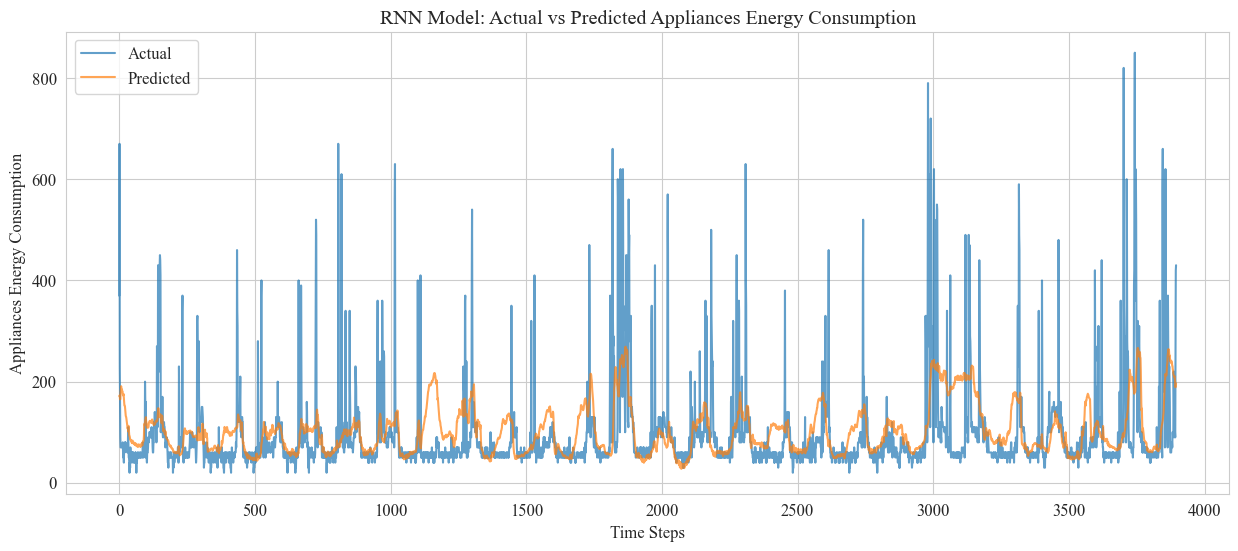

In [29]:
# plot predictions vs actuals
plt.figure(figsize=(15,6))
plt.plot(all_targets_rescaled, label='Actual', alpha=0.7)
plt.plot(all_preds_rescaled, label='Predicted', alpha=0.7)
plt.title('RNN Model: Actual vs Predicted Appliances Energy Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Appliances Energy Consumption')
plt.legend()
plt.show()
